# Change in Occupancy Analysis
This Notebook will use the method detailed in Wang et al. (2024) to use review counts to estimate changes in Airbnb occupancy between 2022-2023. This will then be analysed spatially.

**Stages to the workflow:**
1. Data processing
2. Occupancy metric calculation
3. Spatial autocorrelation and cluster (if any) identification
4. (depending on what shows up) Regression analysis

In [48]:
#Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import os
from scipy.stats import ttest_rel
import duckdb as db
print(os.getcwd())

/home/jovyan/work/CASA0013 - Foundations of Spatial Data Science/CASA0013_FSDS_Airbnb-data-analytics/Documentation


## 1) Data Processing

In [2]:
#Load in both datasets
listings_url = "data/clean/listings_provisonal.csv"
reviews_url = "data/clean/reviews_provisional.csv"

listings = pd.read_csv(listings_url)
reviews = pd.read_csv(reviews_url)

In [3]:
#Filtering reviews to desired time period (removing this now we're looking at both time periods)
#reviews = reviews[(reviews['date'] >= '2022-01-01') & (reviews['date'] < '2024-01-01')]
print(f"First review in dataset: {reviews.date.min()}")
print(f"Last review in dataset: {reviews.date.max()}")

First review in dataset: 2022-01-01
Last review in dataset: 2024-09-10


In [4]:
#Create a year column
reviews["date"] = pd.to_datetime(reviews["date"], format="%Y-%m-%d")
reviews['year'] = reviews.date.dt.year
#reviews.drop(columns = ['year_category'], inplace=True)

In [5]:
print(listings.columns.to_list())

['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [6]:
#Get location data
listings = gpd.GeoDataFrame(listings, geometry = gpd.points_from_xy(listings.longitude, 
                                                                    listings.latitude,
                                                                    crs ='epsg:4326'))

In [7]:
#Keep info for occupancy calculations
listings = listings[["id", "minimum_nights", "geometry"]]
listings.head()

,id,minimum_nights,geometry
0,13913,1,POINT (-0.1127 51.56861)
1,15400,4,POINT (-0.16813 51.4878)
2,17402,3,POINT (-0.14094 51.52195)
3,24328,2,POINT (-0.16266 51.47072)
4,33332,2,POINT (-0.32498 51.4641)


In [8]:
#Noting unrealistic properties
#Some of these are clearly hotels rather than STLs
#But we are measuring overall popularity of the platform, rather than individual listing popularity
#Plus they'll be capped anyway which will reduce their impact
#But noting these here in case we come back to them in the future
reviews.listing_id.value_counts()

listing_id
47408549               1263
43120947               1227
30760930               1084
46233904                785
47438714                736
                       ... 
1231885742573409791       1
1231906795678092700       1
1227368241134072098       1
1227422101962855034       1
1227453717901639468       1
Name: count, Length: 57330, dtype: int64

In [9]:
#Keeping these for later if needed
review_counts = reviews['listing_id'].value_counts().reset_index()
review_counts.columns = ['listing_id', 'count_reviews2223']
high_reviews = review_counts[review_counts.count_reviews2223 > 365]
high_reviews.count_reviews2223.describe()

count      20.000000
mean      605.750000
std       280.332674
min       369.000000
25%       405.250000
50%       501.000000
75%       700.750000
max      1263.000000
Name: count_reviews2223, dtype: float64

## 2) Occupancy Metric Calculation

1. Calculate total reviews for each listing per year
2. Divide these by the presumed review rate (0.5)
3. Join to the minimum stay length from Airbnb dataset and multiply by minimum number of days
4. Multiply this by review rate
5. Cap at 21 nights per month
6. Sum by LSOA
7. Calculate percentage change between years

In [10]:
#Step 1
annual_reviews = reviews.groupby(['listing_id', 'year']).size().unstack(fill_value=0)
annual_reviews.rename(columns={2022: '2022_reviews', 2023: '2023_reviews'}, inplace=True)
annual_reviews = annual_reviews.reset_index()
annual_reviews.columns.name = None

#Step 2
annual_reviews['2022_reviews_rate_adjusted'] = annual_reviews['2022_reviews']/0.5
annual_reviews['2023_reviews_rate_adjusted'] = annual_reviews['2023_reviews']/0.5

#Step 3
annual_reviews = annual_reviews.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews[annual_reviews.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews['estimated_stay'] = np.maximum(3, annual_reviews.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews = gpd.GeoDataFrame(annual_reviews, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews['2022_estimated_nights'] = annual_reviews['2022_reviews_rate_adjusted'] * annual_reviews.estimated_stay
annual_reviews['2023_estimated_nights'] = annual_reviews['2023_reviews_rate_adjusted'] * annual_reviews.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews['2022_estimated_nights'])
annual_reviews['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews['2023_estimated_nights'])

annual_reviews.head()

,listing_id,2022_reviews,2023_reviews,2024,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,geometry,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
0,13913,19,1,3,38.0,2.0,1,POINT (-0.1127 51.56861),3,114.0,6.0,114.0,6.0
1,15400,3,2,2,6.0,4.0,4,POINT (-0.16813 51.4878),4,24.0,16.0,24.0,16.0
2,17402,10,1,1,20.0,2.0,3,POINT (-0.14094 51.52195),3,60.0,6.0,60.0,6.0
3,24328,3,0,0,6.0,0.0,2,POINT (-0.16266 51.47072),3,18.0,0.0,18.0,0.0
4,33332,8,0,0,16.0,0.0,2,POINT (-0.32498 51.4641),3,48.0,0.0,48.0,0.0


count    57330.000000
mean        31.663632
std         60.928975
min          0.000000
25%          0.000000
50%          0.000000
75%         36.000000
max        252.000000
Name: 2022_estimates_nights_capped, dtype: float64


<Axes: ylabel='Frequency'>

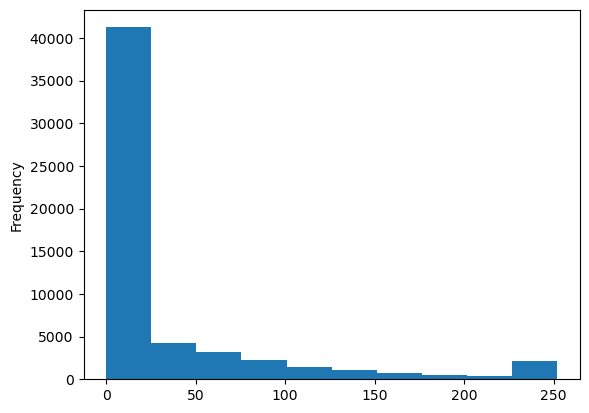

In [11]:
#Quick summary stats
print(annual_reviews['2022_estimates_nights_capped'].describe())
annual_reviews['2022_estimates_nights_capped'].plot.hist()

count    57330.000000
mean        49.121786
std         70.352006
min          0.000000
25%          0.000000
50%         18.000000
75%         72.000000
max        252.000000
Name: 2023_estimates_nights_capped, dtype: float64


<Axes: ylabel='Frequency'>

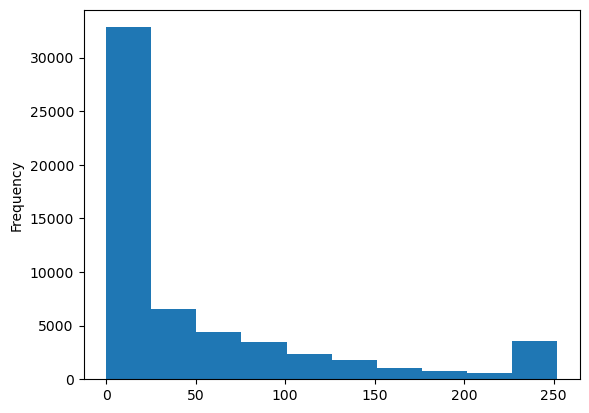

In [12]:
print(annual_reviews['2023_estimates_nights_capped'].describe())
annual_reviews['2023_estimates_nights_capped'].plot.hist()

In [13]:
#Load in LSOAs
#Data source: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
lsoa_url = 'data/LSOA_2011_London_gen_MHW.shp'
lsoas = gpd.read_file(lsoa_url)
columns_to_keep = ['LSOA11CD', 'LSOA11NM', 'geometry']
lsoas = lsoas.loc[:, columns_to_keep]
print(f'LSOA projection: {lsoas.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection
annual_reviews = annual_reviews.to_crs(lsoas.crs)
print(f'\nNew listings projection: {annual_reviews.crs}')

lsoas.rename(columns={'LSOA11CD': 'lsoa_code', 'LSOA11NM': 'lsoa_name'}, inplace=True)

lsoas.head()

LSOA projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Listings projection: epsg:4326

New listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scal

,lsoa_code,lsoa_name,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [14]:
#Step 6
#Join listings to LSOAs - within isn't working but intersects is! Why?
occupancy_by_lsoa = gpd.sjoin(lsoas, annual_reviews, how = 'left', predicate = 'intersects')

#Sum estimated nights per LSOA
lsoa_estimates = occupancy_by_lsoa.groupby('lsoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on LSOA name and geometry from previous dataframe
lsoa_estimates = lsoa_estimates.merge(lsoas, on='lsoa_code', how='left')
lsoa_estimates = gpd.GeoDataFrame(lsoa_estimates, geometry='geometry', crs=annual_reviews.crs)

In [15]:
#Step 7
lsoa_estimates['pct_occ_change'] = round(100*(lsoa_estimates['2023_estimates_nights_capped']-lsoa_estimates['2022_estimates_nights_capped'])/lsoa_estimates['2022_estimates_nights_capped'], 3)

<Axes: >

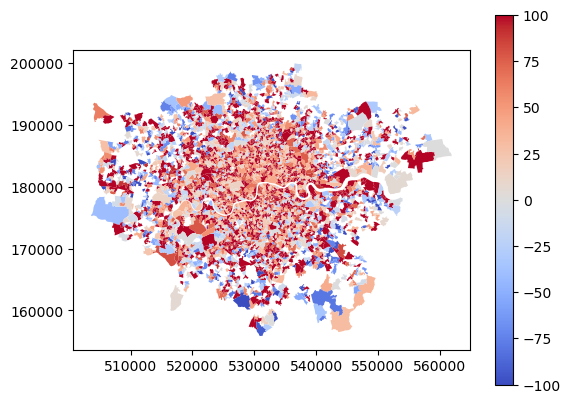

In [16]:
lsoa_estimates.pct_occ_change.min() #min is -100% (float -> 0)
lsoa_estimates.pct_occ_change.max() #max is infinity
lsoa_estimates[lsoa_estimates.pct_occ_change == np.inf] #this is all 0 -> float
lsoa_estimates[lsoa_estimates.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)
#So much heterogeneity!! Would wards be better?

<Axes: >

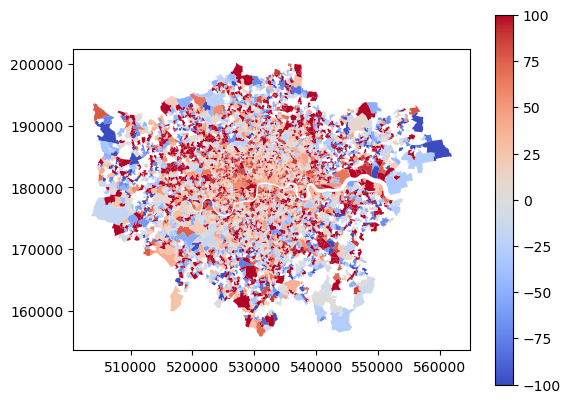

In [17]:
#Does this change if I use 2022-23 and 2023-24 categories instead?
#Step 1
annual_reviews2 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews2.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews2 = annual_reviews2.reset_index()
annual_reviews2.columns.name = None

#Step 2
annual_reviews2['2022_reviews_rate_adjusted'] = annual_reviews2['2022_reviews']/0.5
annual_reviews2['2023_reviews_rate_adjusted'] = annual_reviews2['2023_reviews']/0.5

#Step 3
annual_reviews2 = annual_reviews2.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews2[annual_reviews2.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews2['estimated_stay'] = np.maximum(3, annual_reviews2.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews2 = gpd.GeoDataFrame(annual_reviews2, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews2['2022_estimated_nights'] = annual_reviews2['2022_reviews_rate_adjusted'] * annual_reviews2.estimated_stay
annual_reviews2['2023_estimated_nights'] = annual_reviews2['2023_reviews_rate_adjusted'] * annual_reviews2.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews2['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews2['2022_estimated_nights'])
annual_reviews2['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews2['2023_estimated_nights'])

#Step 6
annual_reviews2 = annual_reviews2.to_crs(lsoas.crs)

#Join listings to LSOAs - within isn't working but intersects is! Why?
occupancy_by_lsoa2 = gpd.sjoin(lsoas, annual_reviews2, how = 'left', predicate = 'intersects')

#Sum estimated nights per LSOA
lsoa_estimates2 = occupancy_by_lsoa2.groupby('lsoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on LSOA name and geometry from previous dataframe
lsoa_estimates2 = lsoa_estimates2.merge(lsoas, on='lsoa_code', how='left')
lsoa_estimates2 = gpd.GeoDataFrame(lsoa_estimates2, geometry='geometry', crs=annual_reviews2.crs)

#Step 7
lsoa_estimates2['pct_occ_change'] = round(100*(lsoa_estimates2['2023_estimates_nights_capped']-lsoa_estimates2['2022_estimates_nights_capped'])/lsoa_estimates2['2022_estimates_nights_capped'], 3)

lsoa_estimates2.head()
lsoa_estimates2[lsoa_estimates2.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)


In [18]:
lsoa_estimates2['2023_estimates_nights_capped'].sum()-lsoa_estimates2['2022_estimates_nights_capped'].sum()

np.float64(954812.0)

In [19]:
lsoa_estimates['2023_estimates_nights_capped'].sum()-lsoa_estimates['2022_estimates_nights_capped'].sum()

np.float64(1000426.0)

In [20]:
lsoa_estimates2[lsoa_estimates2.pct_occ_change == np.inf] #this is all 0 -> float

,lsoa_code,2022_estimates_nights_capped,2023_estimates_nights_capped,lsoa_name,geometry,pct_occ_change
22,E01000024,0.0,12.0,Barking and Dagenham 008D,"POLYGON ((547104.969 185893.124, 547171.488 18...",inf
43,E01000046,0.0,54.0,Barking and Dagenham 017D,"POLYGON ((547292.948 183854.043, 546980.835 18...",inf
44,E01000048,0.0,30.0,Barking and Dagenham 021B,"POLYGON ((544633.054 183501.943, 544642.179 18...",inf
45,E01000049,0.0,22.0,Barking and Dagenham 021C,"POLYGON ((544992.046 183576.059, 544996.61 183...",inf
55,E01000059,0.0,12.0,Barking and Dagenham 013C,"POLYGON ((548679.596 184374.666, 548702.084 18...",inf
...,...,...,...,...,...,...
4678,E01032743,0.0,28.0,Ealing 010F,"POLYGON ((512775.732 182599.765, 512769.268 18...",inf
4714,E01033083,0.0,172.0,Hounslow 018F,"POLYGON ((514063 175711, 513899 175584, 513792...",inf
4747,E01033487,0.0,456.0,Islington 011F,"POLYGON ((530921 185272.027, 530808.642 185179...",inf
4776,E01033589,0.0,18.0,Redbridge 030H,"POLYGON ((544562.757 186870.773, 544601.979 18...",inf


So growth is still fast, but has somewhat slowed relative to the previous 9 months?

n.b. both maps aren't great as I have filtered out infinities

Either we need to keep in infinities *and* -100%, or remove both

Or aggregate by wards/MSOAs for clearer patterns? And to hopefully have fewer -100s/infinities?

In [21]:
#what is the avg number of airbnbs per lsoa?
#occupancy_by_lsoa2.groupby('lsoa_code')
occupancy_by_lsoa2.groupby('lsoa_code')[['listing_id']].count().describe()
#yeah i think we might have to do a different aggregation, if 25% of LSOAs only contain 2 listings - very susceptible to large changes

,listing_id
count,4835.000000
mean,11.853568
std,19.332544
min,0.000000
25%,2.000000
50%,6.000000
75%,14.000000
max,371.000000


## Trying again with MSOAs

In [22]:
#Focusing on 2023-2024

#Load in MSOAs
msoa_url = 'data/MSOA_2011_London_gen_MHW.shp'
msoas = gpd.read_file(msoa_url)
columns_to_keep = ['MSOA11CD', 'MSOA11NM', 'geometry']
msoas = msoas.loc[:, columns_to_keep]
print(f'MSOA projection: {msoas.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection (I did this above so commented it out here)
#annual_reviews = annual_reviews.to_crs(lsoas.crs)
#print(f'\nNew listings projection: {annual_reviews.crs}')

msoas.rename(columns={'MSOA11CD': 'msoa_code', 'MSOA11NM': 'msoa_name'}, inplace=True)

msoas.describe()

MSOA projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["fa

,msoa_code,msoa_name,geometry
count,983,983,983
unique,983,983,983
top,E02006931,Greenwich 038,POLYGON ((529196.7149997593 194422.34599978026...
freq,1,1,1


,msoa_code,msoa_name,geometry,index_right,listing_id,2022_reviews,2023_reviews,Pre-Cutoff,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",47366.0,1.099118e+18,0.0,1.0,0.0,0.0,2.0,3.0,3.0,0.0,6.0,0.0,6.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",15654.0,4.677340e+07,0.0,0.0,6.0,0.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",18291.0,5.265525e+07,1.0,2.0,0.0,2.0,4.0,3.0,3.0,6.0,12.0,6.0,12.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",38496.0,9.587376e+17,0.0,70.0,0.0,0.0,140.0,1.0,3.0,0.0,420.0,0.0,252.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",23290.0,6.624709e+17,0.0,0.0,1.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0


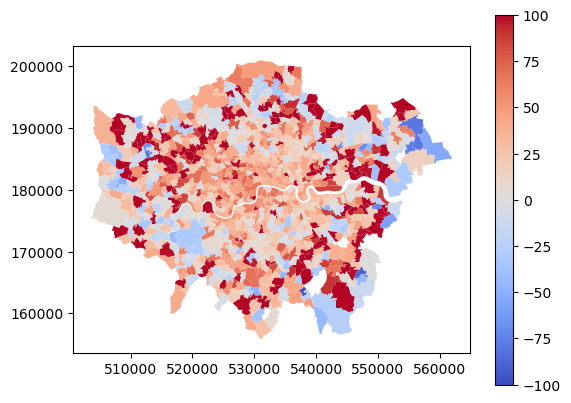

In [23]:
#Recalculate 2022-2023 with MSOAs
#Step 1
annual_reviews3 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews3.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews3 = annual_reviews3.reset_index()
annual_reviews3.columns.name = None

#Step 2
annual_reviews3['2022_reviews_rate_adjusted'] = annual_reviews3['2022_reviews']/0.5
annual_reviews3['2023_reviews_rate_adjusted'] = annual_reviews3['2023_reviews']/0.5

#Step 3
annual_reviews3 = annual_reviews3.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews3[annual_reviews3.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews3['estimated_stay'] = np.maximum(3, annual_reviews3.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews3 = gpd.GeoDataFrame(annual_reviews3, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews3['2022_estimated_nights'] = annual_reviews3['2022_reviews_rate_adjusted'] * annual_reviews3.estimated_stay
annual_reviews3['2023_estimated_nights'] = annual_reviews3['2023_reviews_rate_adjusted'] * annual_reviews3.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews3['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews3['2022_estimated_nights'])
annual_reviews3['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews3['2023_estimated_nights'])

#Step 6
annual_reviews3 = annual_reviews3.to_crs(msoas.crs)

#Join listings to MSOAs - within isn't working but intersects is! Why?
occupancy_by_msoa3 = gpd.sjoin(msoas, annual_reviews3, how = 'left', predicate = 'intersects')

#Sum estimated nights per MSOA
msoa_estimates3 = occupancy_by_msoa3.groupby('msoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on MSOA name and geometry from previous dataframe
msoa_estimates3 = msoa_estimates3.merge(msoas, on='msoa_code', how='left')
msoa_estimates3 = gpd.GeoDataFrame(msoa_estimates3, geometry='geometry', crs=annual_reviews3.crs)

#Step 7
msoa_estimates3['pct_occ_change'] = round(100*(msoa_estimates3['2023_estimates_nights_capped']-msoa_estimates3['2022_estimates_nights_capped'])/msoa_estimates3['2022_estimates_nights_capped'], 3)

msoa_estimates3.head()
msoa_estimates3[msoa_estimates3.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)

#msoa_estimates3[(msoa_estimates3.pct_occ_change!=np.inf) & (msoa_estimates3.pct_occ_change<200)].pct_occ_change.plot.hist(bins=20)

#Work out scale - and maybe cap percentage changes?
#Remove -100s and infinities

msoa_estimates3.loc[np.isfinite(msoa_estimates3.pct_occ_change), :].loc[
    msoa_estimates3.loc[np.isfinite(msoa_estimates3.pct_occ_change), 'pct_occ_change'].idxmax()
]

occupancy_by_msoa3[occupancy_by_msoa3.msoa_code=='E02000026']
#change listing id data type
#look at this in more detail!! work out what to do with these massive increases. it's a problem with percentages

#1) look into problems - work out what it is and change method
#2) Use wards instead
#3) absolute change divided by area or another metric (but this is probs a bad idea)

#(and sort out infs and -100)

## Trying with wards

In [24]:
#Load in wards
wards_url = 'data/London_Ward_CityMerged.shp'
wards = gpd.read_file(wards_url)
columns_to_keep = ['NAME', 'GSS_CODE', 'geometry']
wards = wards.loc[:, columns_to_keep]
print(f'Wards projection: {wards.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection (I did this above so commented it out here)
#annual_reviews = annual_reviews.to_crs(lsoas.crs)
#print(f'\nNew listings projection: {annual_reviews.crs}')

wards.rename(columns={'GSS_CODE': 'ward_code', 'NAME': 'ward_name'}, inplace=True)

wards.describe()

Wards projection: EPSG:27700

Listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,ward_name,ward_code,geometry
count,633,633,633
unique,615,633,633
top,Lea Bridge,E05009297,POLYGON ((530363.1970377553 169850.90001745807...
freq,2,1,1


count    632.000000
mean      41.246191
std       75.366408
min      -83.775000
25%       10.199000
50%       30.854000
75%       53.179500
max      942.857000
Name: pct_occ_change, dtype: float64

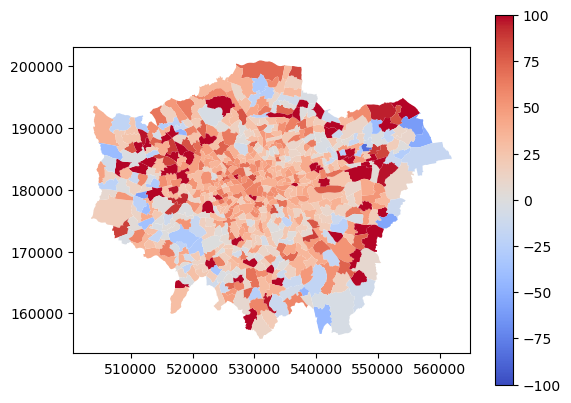

In [25]:
#Recalculate 2022-2023 with wards
#Step 1
annual_reviews4 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews4.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews4 = annual_reviews4.reset_index()
annual_reviews4.columns.name = None

#Step 2
annual_reviews4['2022_reviews_rate_adjusted'] = annual_reviews4['2022_reviews']/0.5
annual_reviews4['2023_reviews_rate_adjusted'] = annual_reviews4['2023_reviews']/0.5

#Step 3
annual_reviews4 = annual_reviews4.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews4[annual_reviews4.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews4['estimated_stay'] = np.maximum(3, annual_reviews4.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews4 = gpd.GeoDataFrame(annual_reviews4, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews4['2022_estimated_nights'] = annual_reviews4['2022_reviews_rate_adjusted'] * annual_reviews4.estimated_stay
annual_reviews4['2023_estimated_nights'] = annual_reviews4['2023_reviews_rate_adjusted'] * annual_reviews4.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews4['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews4['2022_estimated_nights'])
annual_reviews4['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews4['2023_estimated_nights'])

#Step 6
annual_reviews4 = annual_reviews4.to_crs(wards.crs)

#Join listings to wards - within isn't working but intersects is! Why?
occupancy_by_wards4 = gpd.sjoin(wards, annual_reviews4, how = 'left', predicate = 'intersects')

#Sum estimated nights per wards
wards_estimates4 = occupancy_by_wards4.groupby('ward_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on ward name and geometry from previous dataframe
wards_estimates4 = wards_estimates4.merge(wards, on='ward_code', how='left')
wards_estimates4 = gpd.GeoDataFrame(wards_estimates4, geometry='geometry', crs=annual_reviews4.crs)

#Step 7
wards_estimates4['pct_occ_change'] = round(100*(wards_estimates4['2023_estimates_nights_capped']-wards_estimates4['2022_estimates_nights_capped'])/wards_estimates4['2022_estimates_nights_capped'], 3)

wards_estimates4.head()
wards_estimates4[wards_estimates4.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)

wards_estimates4.pct_occ_change.describe()

In [26]:
annual_reviews4.sample(10)

,listing_id,2022_reviews,2023_reviews,Pre-Cutoff,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,geometry,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
4847,15988694,125,105,93,250.0,210.0,1,POINT (519235.767 186247.198),3,750.0,630.0,252.0,252.0
19150,53698163,0,0,1,0.0,0.0,1,POINT (519510.326 186279.249),3,0.0,0.0,0.0,0.0
32317,866699940325414369,5,11,0,10.0,22.0,3,POINT (524386.786 177704.415),3,30.0,66.0,30.0,66.0
47690,1103482611659910342,0,7,0,0.0,14.0,2,POINT (537593.04 179430.304),3,0.0,42.0,0.0,42.0
37010,938196814861769185,2,22,0,4.0,44.0,3,POINT (538043.839 176404.602),3,12.0,132.0,12.0,132.0
52032,1158747258616916034,0,7,0,0.0,14.0,3,POINT (535773.999 178405.866),3,0.0,42.0,0.0,42.0
3810,12849955,0,20,0,0.0,40.0,1,POINT (529121.927 185339.847),3,0.0,120.0,0.0,120.0
31152,845574228049061161,10,7,0,20.0,14.0,2,POINT (529450.581 184395.173),3,60.0,42.0,60.0,42.0
36242,927594416074378818,0,12,0,0.0,24.0,2,POINT (524017.016 173183.501),3,0.0,72.0,0.0,72.0
10027,30685943,24,26,23,48.0,52.0,5,POINT (528373.931 185035.806),5,240.0,260.0,240.0,252.0


<Axes: ylabel='Frequency'>

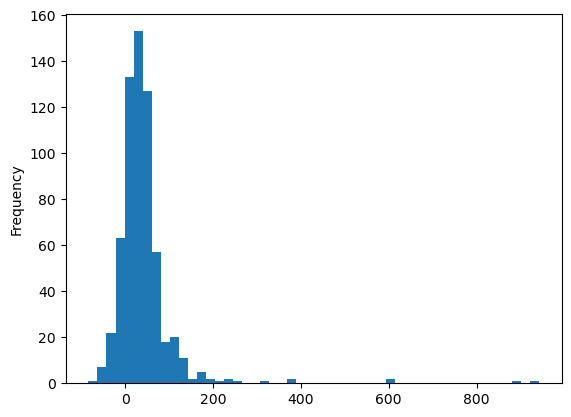

In [27]:
wards_estimates4[wards_estimates4.pct_occ_change!=np.inf].pct_occ_change.plot.hist(bins=50)

In [87]:
#Paired samples t-test
#To see whether the change in occupancy is statistically significant

print('Paired sample t-test for changes in Airbnb occupancy across London wards between Sept 2022-23, and Sept 2023-2024')
print('\nH0: No significant difference in mean Airbnb occupancy per ward between 2022-23 and 2023-24.')
print('H1: There is a significant difference in mean Airbnb occupancy per ward between 2022-23 and 2023-24.')

year1 = wards_estimates4['2022_estimates_nights_capped']
year2 = wards_estimates4['2023_estimates_nights_capped']
alpha = 0.05

t_stat, p_value = ttest_rel(year1, year2)

print(f'\nT-statistic: {t_stat}')
print(f'P-value: {p_value}')

if p_value > alpha:
    print('\nInsufficient evidence to reject H0. There was no significant difference in occupancy per ward between 2022-23 and 2023-24.')
else:
    print('\nSufficient evidence to reject H0 and tentatively accept H1. There was a statistically significant difference in occupancy per ward between 2022-23 and 2023-24.')

print(f'\nThe mean cumulative number of Airbnb nights per ward in 2022-2023 was {wards_estimates4["2022_estimates_nights_capped"].mean():.2f}.')
print(f'The mean cumulative number of Airbnb nights per ward in 2023-2024 was {wards_estimates4["2023_estimates_nights_capped"].mean():.2f}.')

Paired sample t-test for changes in Airbnb occupancy across London wards between Sept 2022-23, and Sept 2023-2024
H0: No significant difference in mean Airbnb occupancy per ward between 2022-23 and 2023-24.
H1: There is a significant difference in mean Airbnb occupancy per ward between 2022-23 and 2023-24.

T-statistic: -13.469219586311432
P-value: 1.5559524597669734e-36

Sufficient evidence to reject H0 and tentatively accept H1. There was a statistically significant difference in occupancy per ward between 2022-23 and 2023-24.

The mean cumulative number of Airbnb nights per ward in 2022-2023 was 3978.45.
The mean cumulative number of Airbnb nights per ward in 2023-2024 was 5487.05.


In [90]:
#Paired samples t-test
#To see whether the change in number of Airbnbs per ward is statistically significant

#Using review data to more accurately filter for Airbnbs (I tried with listings, but some had since been deleted)
#Naturally, review data will only be "active" Airbnbs - slight flaw, but essentially I am just tracking whether a listing had 1 review in that time period

listing_count = annual_reviews4.copy()[['listing_id', 'geometry', '2022_reviews', '2023_reviews']]
listing_count['active_2022'] = listing_count['2022_reviews']>0
listing_count['active_2023'] = listing_count['2023_reviews']>0

#Join listings to wards
listing_count = gpd.sjoin(wards, listing_count, how = 'left', predicate = 'intersects')

#Sum active listings per year per ward
listing_count = listing_count.groupby('ward_code')[['active_2022', 'active_2023']].sum()

#Paired sample t-test
print('Paired sample t-test for changes in number of Airbnbs in London wards between Sept 2022-23, and Sept 2023-2024')
print('\nH0: No significant difference in mean number of Airbnbs per ward between 2022-23 and 2023-24.')
print('H1: There is a significant difference in mean number of Airbnbs per ward between 2022-23 and 2023-24.')

year1 = listing_count['active_2022']
year2 = listing_count['active_2023']
alpha = 0.05

t_stat, p_value = ttest_rel(year1, year2)

print(f'\nT-statistic: {t_stat}')
print(f'P-value: {p_value}')

if p_value > alpha:
    print('\nInsufficient evidence to reject H0. There was no significant difference in number of Airbnbs per ward between 2022-23 and 2023-24.')
else:
    print('\nSufficient evidence to reject H0 and tentatively accept H1. There was a statistically significant difference in number of Airbnbs per ward between 2022-23 and 2023-24.')

print(f'\nThe mean number of active Airbnbs per ward in 2022-2023 was {listing_count.active_2022.mean():.2f}.')
print(f'The mean number of active Airbnbs per ward in 2023-2024 was {listing_count.active_2023.mean():.2f}.')

Paired sample t-test for changes in number of Airbnbs in London wards between Sept 2022-23, and Sept 2023-2024

H0: No significant difference in mean number of Airbnbs per ward between 2022-23 and 2023-24.
H1: There is a significant difference in mean number of Airbnbs per ward between 2022-23 and 2023-24.

T-statistic: -16.93046993095679
P-value: 2.662933706550959e-53

Sufficient evidence to reject H0 and tentatively accept H1. There was a statistically significant difference in number of Airbnbs per ward between 2022-23 and 2023-24.

The mean number of active Airbnbs per ward in 2022-2023 was 50.51.
The mean number of active Airbnbs per ward in 2023-2024 was 77.81.


**Next steps/takeaways:**
- More recent data seems to show more decreases - fits with what we thought
- LSOAs don't work, wards are the best scale probably as they don't have as many infinities
    - But not as much detail as MSOAs
    - Ward justification: at this scale enough cumulative listings to reduce instability from individual listing openings/closures
- Need to look into massive percentage changes: need to look into individual outlier

### Boroughs Test
Unlikely we'll use this, but just wondering whether a larger spatial scale might help reduce massive percentage changes

Boroughs projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER

count    33.000000
mean     32.663000
std      13.049372
min       4.780000
25%      24.217000
50%      35.713000
75%      40.832000
max      55.102000
Name: pct_occ_change, dtype: float64

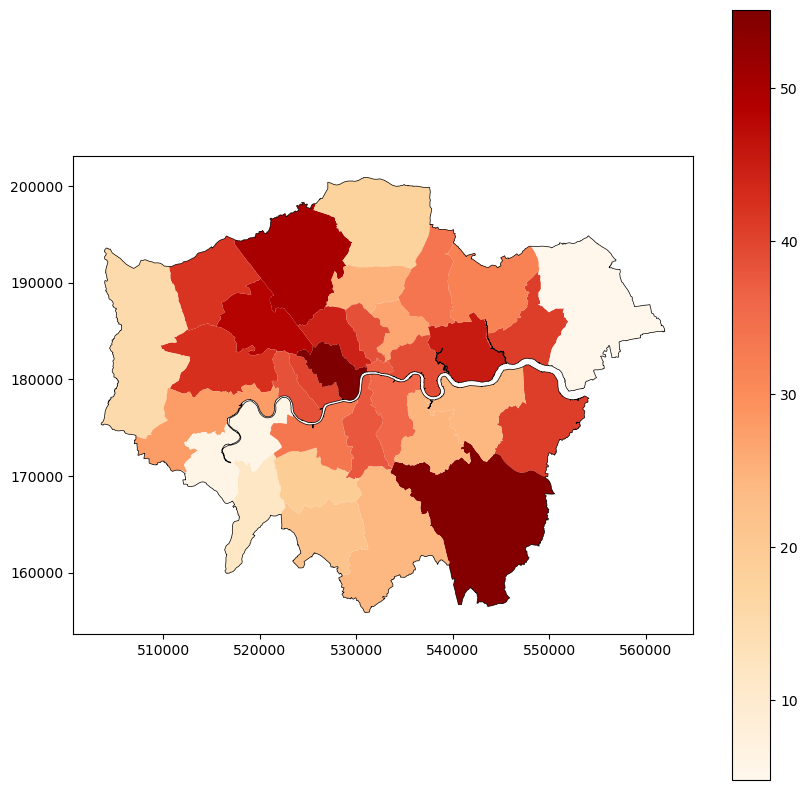

In [113]:
#Load in boroughs
boroughs = gpd.read_file('data/London_Borough_Excluding_MHW.shp')
columns_to_keep = ['NAME', 'GSS_CODE', 'geometry']
boroughs = boroughs.loc[:, columns_to_keep]
print(f'Boroughs projection: {boroughs.crs}')
print(f'\nListings projection: {annual_reviews4.crs}')

if boroughs.crs != annual_reviews4.crs:
    print('\nProjections are not equal.')
    annual_reviews4 = annual_reviews4.to_crs(boroughs.crs)
    print(f'New listings projection: {annual_reviews4.crs}')
else:
    print('Projections are the same.')

boroughs.rename(columns={'GSS_CODE': 'borough_code', 'NAME': 'borough_name'}, inplace=True)

#Join listings to boroughs - within isn't working but intersects is! Why?
occupancy_by_boroughs = gpd.sjoin(boroughs, annual_reviews4, how = 'left', predicate = 'intersects')

#Sum estimated nights per borough
boroughs_estimates = occupancy_by_boroughs.groupby('borough_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on borough name and geometry from previous dataframe
boroughs_estimates = boroughs_estimates.merge(boroughs, on='borough_code', how='left')
boroughs_estimates = gpd.GeoDataFrame(boroughs_estimates, geometry='geometry', crs=annual_reviews4.crs)

#Step 7
boroughs_estimates['pct_occ_change'] = round(100*(boroughs_estimates['2023_estimates_nights_capped']-boroughs_estimates['2022_estimates_nights_capped'])/boroughs_estimates['2022_estimates_nights_capped'], 3)

fig, ax = plt.subplots(figsize=(10, 10))
boroughs_estimates[boroughs_estimates.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="OrRd", legend=True, ax=ax)
boroughs.dissolve().buffer(2).plot(ax=ax, facecolor="none",  edgecolor="black", linewidth=0.5)
boroughs_estimates.pct_occ_change.describe()